In [79]:
%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy.io import fits
from astropy import units as u
import PIL
import regions
import pyavm
import numpy as np
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (10,8)
pl.rcParams['figure.dpi'] = 100
pl.rcParams['font.size'] = 16

In [11]:
from astroquery.vizier import Vizier

In [189]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [190]:
import sys, imp
sys.path.append(f'{basepath}/analysis/')
import plot_tools
imp.reload(plot_tools)

<module 'plot_tools' from '/orange/adamginsburg/jwst/brick//analysis/plot_tools.py'>

In [191]:
from plot_tools import starzoom, make_sed

In [86]:
basetable = Table.read(f'{basepatmake_sedtalogs/crowdsource_nsky0_merged_photometry_tables_merged.fits')

In [87]:
filternames = ['f410m', 'f212n', 'f466n', 'f405n', 'f187n', 'f182m']

In [88]:
any_saturated_ = [basetable[x] for x in basetable.colnames if 'near_sat' in x]
any_saturated = any_saturated_[0]
for row in any_saturated_[1:]:
    #print(row.sum())
    any_saturated = any_saturated | row
magerr_gtpt1 = np.logical_or.reduce([basetable[f'emag_ab_{filtername}'] > 0.2 for filtername in filternames])

In [89]:
oksep = np.logical_or.reduce([basetable[f'sep_{filtername}'] for filtername in filternames[1:]])
blue_410_466 = oksep & ~any_saturated & (~(basetable['mag_ab_410m405'].mask)) & ((basetable['mag_ab_410m405'] - basetable['mag_ab_f466n']) + (basetable['emag_ab_f410m']**2 + basetable['emag_ab_f466n']**2 + basetable['emag_ab_f405n']**2)**0.5 < -1.75)
assert (blue_410_466 & basetable['mag_ab_410m405'].mask).sum() == 0
blue_410_405 = oksep & ~any_saturated & (~(basetable['mag_ab_410m405'].mask)) & ((basetable['mag_ab_410m405'] - basetable['mag_ab_f405n']) + (basetable['emag_ab_f410m']**2 + basetable['emag_ab_f405n']**2)**0.5 < -2)
blue_405_410 = oksep & ~any_saturated & (~(basetable['mag_ab_410m405'].mask)) & ((basetable['mag_ab_405m410'] - basetable['mag_ab_410m405']) + (basetable['emag_ab_f410m']**2 + basetable['emag_ab_f405n']**2)**0.5 < -3)
blue_405_410b = oksep & ~any_saturated & (basetable['flux_f405n'] > basetable['flux_f410m']) & (~(basetable['mag_ab_f405n'].mask)) & ((basetable['mag_ab_f405n'] - basetable['mag_ab_f410m']) + (basetable['emag_ab_f410m']**2 + basetable['emag_ab_f405n']**2)**0.5 < -2) & ~magerr_gtpt1

In [90]:
blue_410_466.sum(), blue_405_410.sum(), blue_405_410b.sum()

(1007, 1796, 4125)

In [91]:
viz = Vizier()

In [92]:
bluetbl = basetable[blue_410_466]
bluetbl.sort('flux_f410m')
bluetbl[-5:]

x_f410m,y_f410m,flux_f410m,passno_f410m,dx_f410m,dy_f410m,dflux_f410m,qf_f410m,rchi2_f410m,fracflux_f410m,fluxlbs_f410m,dfluxlbs_f410m,fwhm_f410m,spread_model_f410m,dspread_model_f410m,fluxiso_f410m,xiso_f410m,yiso_f410m,sky_f410m,skycoord_f410m,flux_jy_f410m,eflux_jy_f410m,mag_ab_f410m,emag_ab_f410m,near_saturated_f410m,sep_f212n,id_f212n,x_f212n,y_f212n,flux_f212n,passno_f212n,dx_f212n,dy_f212n,dflux_f212n,qf_f212n,rchi2_f212n,fracflux_f212n,fluxlbs_f212n,dfluxlbs_f212n,fwhm_f212n,spread_model_f212n,dspread_model_f212n,fluxiso_f212n,xiso_f212n,yiso_f212n,sky_f212n,skycoord_f212n,flux_jy_f212n,eflux_jy_f212n,mag_ab_f212n,emag_ab_f212n,near_saturated_f212n,sep_f466n,id_f466n,x_f466n,y_f466n,flux_f466n,passno_f466n,dx_f466n,dy_f466n,dflux_f466n,qf_f466n,rchi2_f466n,fracflux_f466n,fluxlbs_f466n,dfluxlbs_f466n,fwhm_f466n,spread_model_f466n,dspread_model_f466n,fluxiso_f466n,xiso_f466n,yiso_f466n,sky_f466n,skycoord_f466n,flux_jy_f466n,eflux_jy_f466n,mag_ab_f466n,emag_ab_f466n,near_saturated_f466n,sep_f405n,id_f405n,x_f405n,y_f405n,flux_f405n,passno_f405n,dx_f405n,dy_f405n,dflux_f405n,qf_f405n,rchi2_f405n,fracflux_f405n,fluxlbs_f405n,dfluxlbs_f405n,fwhm_f405n,spread_model_f405n,dspread_model_f405n,fluxiso_f405n,xiso_f405n,yiso_f405n,sky_f405n,skycoord_f405n,flux_jy_f405n,eflux_jy_f405n,mag_ab_f405n,emag_ab_f405n,near_saturated_f405n,sep_f187n,id_f187n,x_f187n,y_f187n,flux_f187n,passno_f187n,dx_f187n,dy_f187n,dflux_f187n,qf_f187n,rchi2_f187n,fracflux_f187n,fluxlbs_f187n,dfluxlbs_f187n,fwhm_f187n,spread_model_f187n,dspread_model_f187n,fluxiso_f187n,xiso_f187n,yiso_f187n,sky_f187n,skycoord_f187n,flux_jy_f187n,eflux_jy_f187n,mag_ab_f187n,emag_ab_f187n,near_saturated_f187n,sep_f182m,id_f182m,x_f182m,y_f182m,flux_f182m,passno_f182m,dx_f182m,dy_f182m,dflux_f182m,qf_f182m,rchi2_f182m,fracflux_f182m,fluxlbs_f182m,dfluxlbs_f182m,fwhm_f182m,spread_model_f182m,dspread_model_f182m,fluxiso_f182m,xiso_f182m,yiso_f182m,sky_f182m,skycoord_f182m,flux_jy_f182m,eflux_jy_f182m,mag_ab_f182m,emag_ab_f182m,near_saturated_f182m,flux_jy_410m405,mag_ab_410m405,flux_jy_405m410,mag_ab_405m410,flux_jy_182m187,mag_ab_182m187,flux_jy_187m182,mag_ab_187m182
,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,Jy,,,,deg,,,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,Jy,,,,deg,,,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,Jy,,,,deg,,,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,Jy,,,,deg,,,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,Jy,,,,deg,,,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,Jy,,,,Jy,,Jy,,Jy,,Jy,
float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float32,float32,bool,float64,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float32,float32,bool,float64,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float32,float32,bool,float64,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float32,float32,bool,float64,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float32,float32,bool,float64,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float32,float32,bool,float32,float32,float32,float32,float32,float32,float32,float32
2820.0014960726403,2293.0546800424922,76382.08,0.0,0.0038644252,0.004026979,130.10335,0.02549865,50003.117,0.34902123,121994.15,207.64719,3.1291769,-0.02426213,8.690144e-05,104565.55,0.02099369115813272,-1.1265137223287724,10.334838,"266.55809473814764

In [93]:
fov = regions.Regions.read(f'{basepath}/regions/nircam_fov.reg')

In [94]:
coord = fov[0].center
height = fov[0].height
width = fov[0].width
height, width = width, height # CARTA wrote it wrong
coord, width, height

(<SkyCoord (ICRS): (ra, dec) in deg
     (266.53496367, -28.71007499)>,
 <Quantity 161.9038 arcsec>,
 <Quantity 391.024 arcsec>)

In [95]:
skycrds_cat = bluetbl['skycoord_f410m']

In [200]:
spitzer = Vizier(row_limit=1e6).query_region(coordinates=coord, width=width*2, height=height*2, catalog=['II/295/SSTGC'])[0]
spitzer_crds = SkyCoord(spitzer['RAJ2000'], spitzer['DEJ2000'], frame='fk5', unit=(u.hour, u.deg))
idx, sidx, sep, sep3d = spitzer_crds.search_around_sky(skycrds_cat, 1*u.arcsec)
len(spitzer), len(idx), len(sidx)

(6022, 8946, 8946)

/scratch/local/52411464/ipykernel_56747/3396868984.py:1: UserWarning: You passed a edgecolor/edgecolors ('b') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  pl.scatter(spitzer_crds.ra[sidx], spitzer_crds.dec[sidx], facecolor='b', edgecolor='b', marker='x')


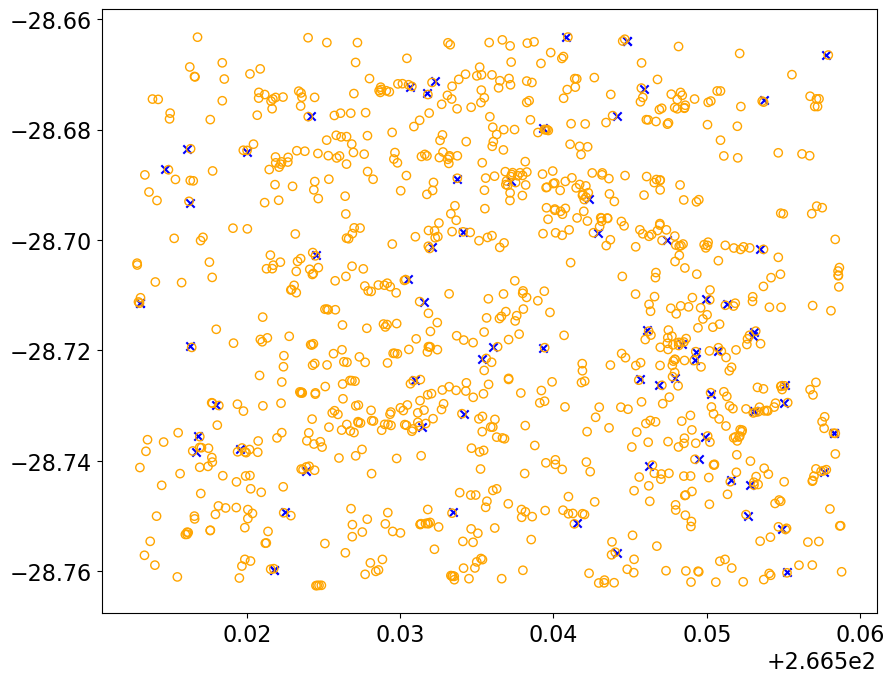

In [97]:
pl.scatter(spitzer_crds.ra[sidx], spitzer_crds.dec[sidx], facecolor='b', edgecolor='b', marker='x')
pl.scatter(skycrds_cat.ra, skycrds_cat.dec, facecolor='none', edgecolor='orange')

Set OBSGEO-B to   -20.631897 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526059356.900 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


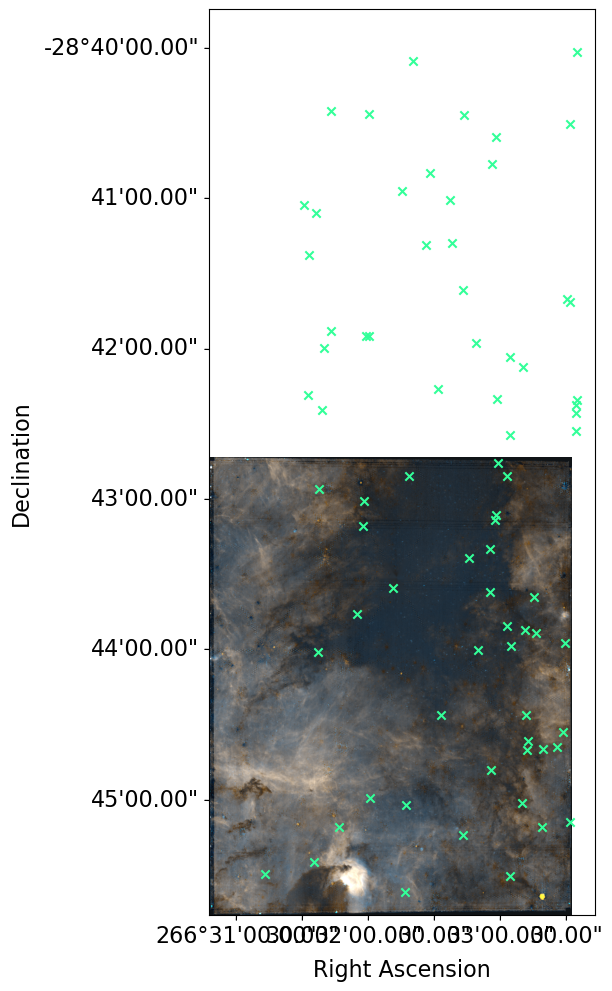

In [98]:
# This image shows only H-alpha stars
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickJWST_nrca_longwave_narrowband_rotated_lighter.png')
img_narrow = np.array(PIL.Image.open(f'{basepath}/images/BrickJWST_nrca_longwave_narrowband_rotated_lighter.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_narrow = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_narrow = img_narrow.swapaxes(0,1)
wwi_narrow = wwi_narrow.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_narrow)
ax.imshow(img_narrow)

crds = basetable['skycoord_f410m']
ax.scatter(
    crds.dec[blue_410_466][idx],
    crds.ra[blue_410_466][idx],
    transform=ax.get_transform('world'),
    marker='x', facecolors=(0.2, 1, 0.6),
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), 
);
#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('dd:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
#lon.set_ticks(spacing=30. * u.arcsec, color='red')
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')
#lon.set_ticklabel(color='red')
#lat.set_ticklabel(color='blue')
#lon.grid(color='red')
#lat.grid(color='blue')

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


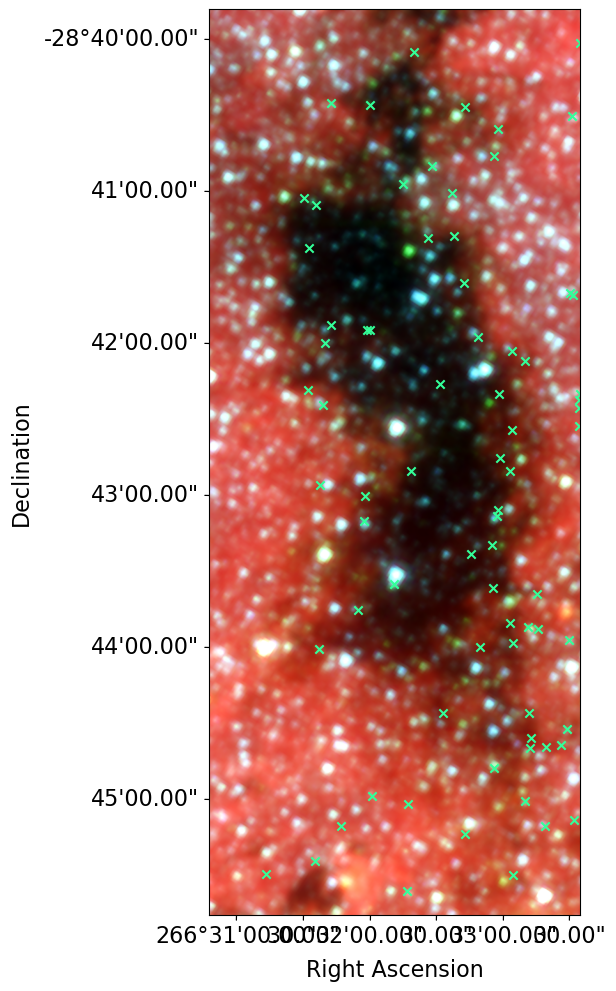

In [99]:
# This image shows only H-alpha stars
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickSpitzer_RGB_I421.png')
img_spitzer = np.array(PIL.Image.open(f'{basepath}/images/BrickSpitzer_RGB_I421.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_spitzer = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_spitzer = img_spitzer.swapaxes(0,1)
wwi_spitzer = wwi_spitzer.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_spitzer)
ax.imshow(img_spitzer)

crds = basetable['skycoord_f410m']
ax.scatter(
    crds.dec[blue_410_466][idx],
    crds.ra[blue_410_466][idx],
    transform=ax.get_transform('world'),
    marker='x', facecolors=(0.2, 1, 0.6),
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), 
);
#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('dd:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
#lon.set_ticks(spacing=30. * u.arcsec, color='red')
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')
#lon.set_ticklabel(color='red')
#lat.set_ticklabel(color='blue')
#lon.grid(color='red')
#lat.grid(color='blue')

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')

In [101]:
spitzer[:3]

SSTGC,RAJ2000,DEJ2000,Jmag,Hmag,Ksmag,_3.6mag,_4.5mag,_5.8mag,_8.0mag,IRAC,_2M
,'h:m:s','d:m:s',mag,mag,mag,mag,mag,mag,mag,,
str7,str11,str11,float32,float32,float32,float32,float32,float32,float32,str4,str2
0569186,17 45 56.09,-28 41 55.2,--,--,--,12.151,--,--,--,IRAC,2M
0569192,17 45 56.09,-28 41 14.7,15.762,13.059,11.779,--,--,--,--,IRAC,2M
0569193,17 45 56.09,-28 45 33.3,--,--,--,11.601,11.340,10.390,--,IRAC,2M


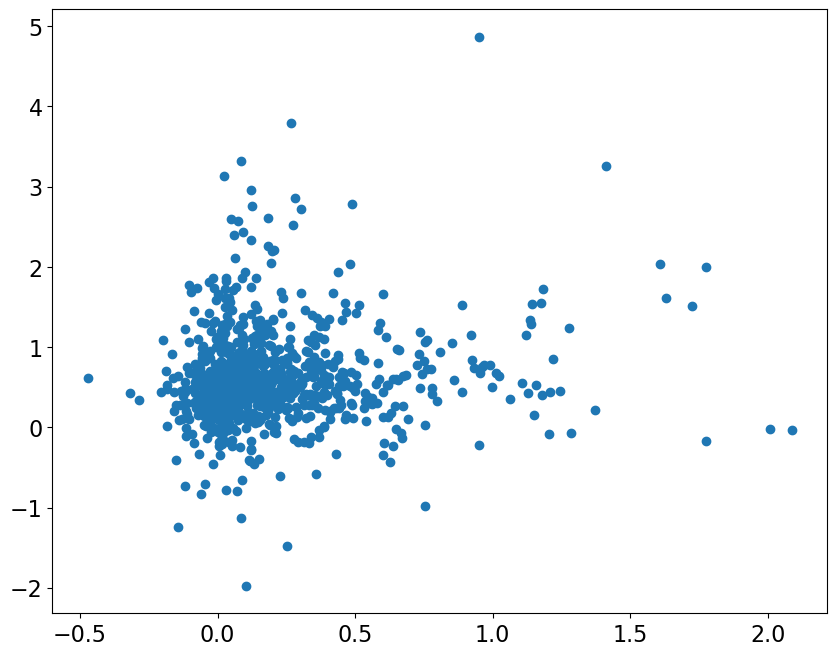

In [102]:
pl.scatter(spitzer['_3.6mag'] - spitzer['_4.5mag'],  spitzer['_4.5mag'] - spitzer['_8.0mag'])

In [110]:
wwi_spitzer.world_to_pixel(spitzer_crds[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0])

(array([-332.82768491, -301.69733563, -287.19583525, -290.52767802,
        -263.77138065, -249.28364559, -214.29212152, -204.57853656,
        -204.22387882, -198.03527824, -214.68760838, -188.13946848,
        -198.83658986, -186.10544106, -166.00340542, -172.64529091,
        -153.95404284, -141.15530161, -154.95132734, -112.267619  ,
        -118.41017824,  -65.23103375,  -83.19412959,  -66.61151222,
         -39.94478493,  -45.72849267,   -9.38995358,  -23.75073262,
         -16.84926654,    4.66086104,    7.54781251,    6.94763763,
          26.45448607,   20.32406318,   40.98150225,   66.08498449,
          93.94570011,  128.4231984 ,  148.99170627,  123.09552557,
         188.01760923,  176.98983891,  196.08575698,  260.12709179,
         262.48012072,  277.73480409,  315.53324653,  382.75976696,
         399.37301432,  411.1733778 ,  398.56227853,  440.5172092 ,
         408.05277904,  446.52683274,  478.03038045,  463.78622616,
         515.09282118,  515.68907643,  582.11651

Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


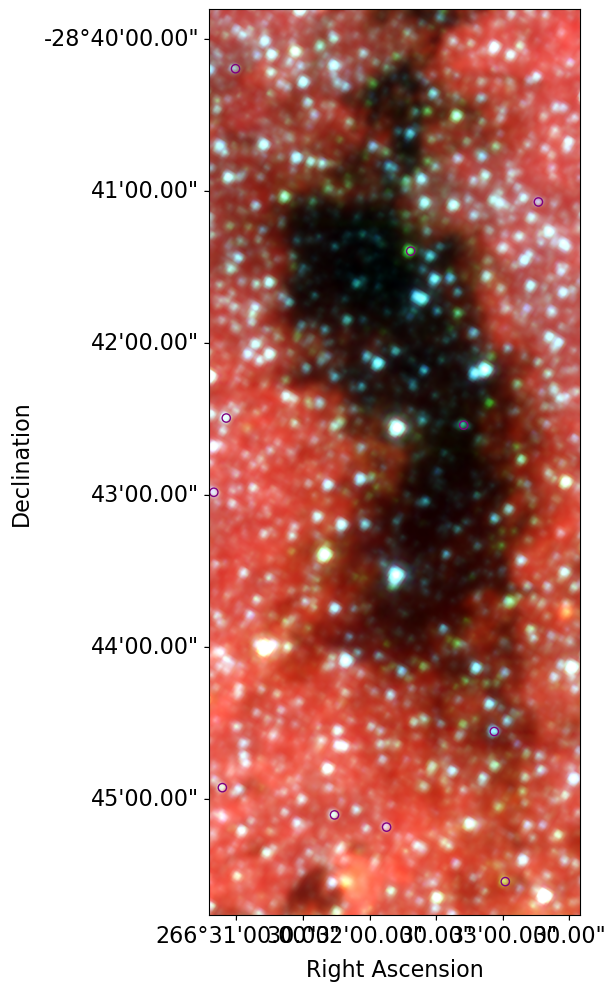

In [120]:
# This image shows only H-alpha stars
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickSpitzer_RGB_I421.png')
img_spitzer = np.array(PIL.Image.open(f'{basepath}/images/BrickSpitzer_RGB_I421.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_spitzer = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_spitzer = img_spitzer.swapaxes(0,1)
wwi_spitzer = wwi_spitzer.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_spitzer)
ax.imshow(img_spitzer)
axlims = ax.axis()

green_spitzer = (spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0)# | ((10 < spitzer['_4.5mag']) & (spitzer['_4.5mag'] < 15) & (spitzer['_8.0mag'].mask))
xx,yy = wwi_spitzer.world_to_pixel(spitzer_crds[green_spitzer])
ax.scatter(
    xx,yy,
    #spitzer_crds.ra[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #spitzer_crds.dec[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #transform=ax.get_transform('fk5'),
    marker='o', edgecolors='purple', facecolors='none',
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), a 
);
#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('dd:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
#lon.set_ticks(spacing=30. * u.arcsec, color='red')
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')
#lon.set_ticklabel(color='red')
#lat.set_ticklabel(color='blue')
#lon.grid(color='red')
#lat.grid(color='blue')

ax.axis(axlims)

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')

In [123]:
coord = SkyCoord('17:46:08.912 -28:41:22.63', frame='fk5', unit=(u.hour, u.deg))
radius = 0.5*u.arcsec

In [126]:
(coord.separation(skycrds_cat) < radius).sum()

4

In [129]:
skycrds_cat = basetable['skycoord_f410m']
idx = coord.separation(skycrds_cat) < radius
if len(idx) == 0:
    raise

spitzer = Vizier.query_region(coordinates=coord, radius=radius, catalog=['II/295/SSTGC'])[0]
if len(spitzer) > 0:
    spitzer_crds = SkyCoord(spitzer['RAJ2000'], spitzer['DEJ2000'], frame='fk5', unit=(u.hour, u.deg))
    spitzindex = coord.separation(spitzer_crds) < radius
    print(len(spitzindex))
    spitzermatch = spitzer[spitzindex]

vvvdr2 = Vizier.query_region(coordinates=coord, radius=0.5*u.arcsec, catalog=['II/348/vvv2'])[0]
if len(spitzer) > 0:
    vvvdr2_crds = SkyCoord(vvvdr2['RAJ2000'], vvvdr2['DEJ2000'], frame='fk5', unit=(u.hour, u.deg))
    vvvindex = coord.separation(vvvdr2_crds) < radius
    print(len(vvvindex))
    vvvmatch = vvvdr2[vvvindex]

1
1


In [132]:
from astroquery.svo_fps import SvoFps

In [133]:
for filtername in filternames:
    telescope = 'JWST'
    instrument = 'NIRCAM'
    wavelength_table = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filtername}')

In [137]:
spitzer[:1]

SSTGC,RAJ2000,DEJ2000,Jmag,Hmag,Ksmag,_3.6mag,_4.5mag,_5.8mag,_8.0mag,IRAC,_2M
,'h:m:s','d:m:s',mag,mag,mag,mag,mag,mag,mag,,
str7,str11,str11,float32,float32,float32,float32,float32,float32,float32,str4,str2
0604691,17 46 08.93,-28 41 22.5,15.819,14.663,12.374,10.953,8.864,8.285,8.895,IRAC,2M


In [178]:
    skycrds_cat = basetable['skycoord_f410m']
    idx = coord.separation(skycrds_cat) < radius
    if len(idx) == 0:
        raise
    else:
        idx = np.argmin(coord.separation(skycrds_cat))

    spitzer = Vizier.query_region(coordinates=coord, radius=radius, catalog=['II/295/SSTGC'])[0]
    if len(spitzer) > 0:
        spitzer_crds = SkyCoord(spitzer['RAJ2000'], spitzer['DEJ2000'], frame='fk5', unit=(u.hour, u.deg))
        spitzindex = coord.separation(spitzer_crds) < radius
        print(len(spitzindex))
        spitzermatch = spitzer[spitzindex]

    vvvdr2 = Vizier.query_region(coordinates=coord, radius=0.5*u.arcsec, catalog=['II/348/vvv2'])[0]
    if len(spitzer) > 0:
        vvvdr2_crds = SkyCoord(vvvdr2['RAJ2000'], vvvdr2['DEJ2000'], frame='fk5', unit=(u.hour, u.deg))
        vvvindex = coord.separation(vvvdr2_crds) < radius
        print(len(vvvindex))
        vvvmatch = vvvdr2[vvvindex]

    wavelengths = []
    fluxes = []
    widths = []
    telescope = 'JWST'
    instrument = 'NIRCAM'
    filter_table = SvoFps.get_filter_list(facility=telescope, instrument=instrument)
    filter_table.add_index('filterID')
    for filtername in filternames:
        instrument = 'NIRCam'
        filtername = filtername.upper()
        eff_wavelength = filter_table.loc[f'{telescope}/{instrument}.{filtername}']['WavelengthEff'] * u.AA
        wavelengths.append(eff_wavelength)
        eff_width = filter_table.loc[f'{telescope}/{instrument}.{filtername}']['WidthEff'] * u.AA
        widths.append(eff_width)
        filtername = filtername.lower()
        fluxes.append(basetable[f'flux_jy_{filtername}'][idx] * u.Jy)


    telescope = 'Spitzer'
    instrument = 'IRAC'
    filter_table = SvoFps.get_filter_list(facility=telescope, instrument=instrument)
    filter_table.add_index('filterID')
    for filtername,colname in [('I1', '_3.6mag'),
                               ('I2', '_4.5mag'),
                               ('I3', '_5.8mag'),
                               ('I4', '_8.0mag')]:
        eff_wavelength = filter_table.loc[f'{telescope}/{instrument}.{filtername}']['WavelengthEff'] * u.AA
        wavelengths.append(eff_wavelength)
        fluxes.append(10**(-spitzer[colname]/2.5) * filter_table.loc[f'{telescope}/{instrument}.{filtername}']['ZeroPoint'] * u.Jy)
        eff_width = filter_table.loc[f'{telescope}/{instrument}.{filtername}']['WidthEff'] * u.AA
        widths.append(eff_width)

1
1


In [186]:
filternames

['f410m', 'f212n', 'f466n', 'f405n', 'f187n', 'f182m']

In [179]:
fluxes, widths

([<Quantity 0.13719383 Jy>,
  <Quantity 0.02637436 Jy>,
  <Quantity 0.04736515 Jy>,
  <Quantity -0.00839414 Jy>,
  <Quantity 0.00204083 Jy>,
  <Quantity 0.00167842 Jy>,
  <Quantity [0.01141275] Jy>,
  <Quantity [0.05058216] Jy>,
  <Quantity [0.05510747] Jy>,
  <Quantity [0.01762665] Jy>],
 [<Quantity 4262.85790239 Angstrom>,
  <Quantity 274.27440341 Angstrom>,
  <Quantity 535.40523943 Angstrom>,
  <Quantity 454.87184789 Angstrom>,
  <Quantity 236.68645057 Angstrom>,
  <Quantity 2250.8124937 Angstrom>,
  <Quantity 6836.18018646 Angstrom>,
  <Quantity 8649.92060205 Angstrom>,
  <Quantity 12561.17490202 Angstrom>,
  <Quantity 25288.49843082 Angstrom>])

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/quantity.py:502: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value, dtype=dtype, copy=copy, order=order,


<ErrorbarContainer object of 3 artists>

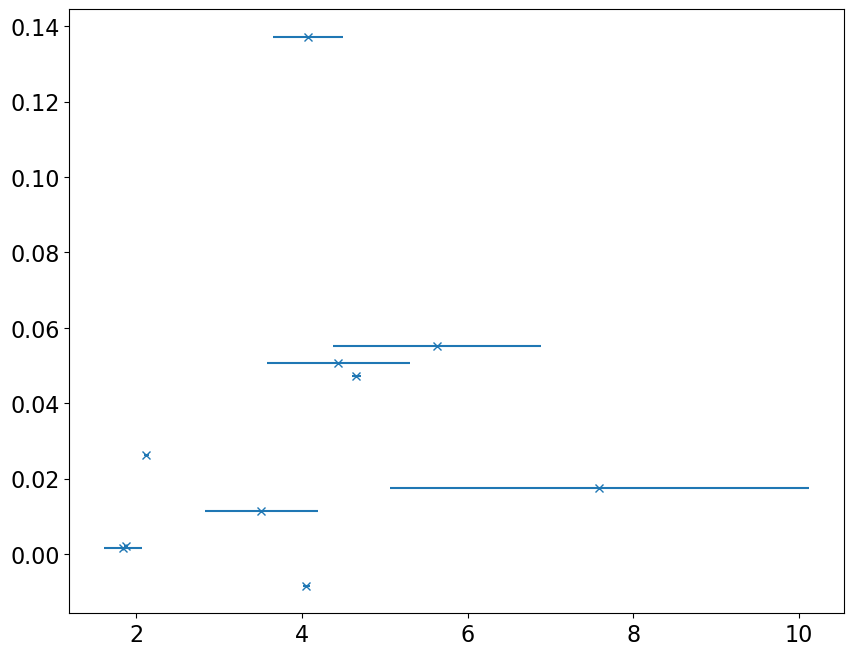

In [180]:
pl.errorbar(u.Quantity(wavelengths, u.um), u.Quantity([u.Quantity(x, u.Jy) for x in fluxes], u.Jy), xerr=widths, linestyle='none', marker='x')

In [195]:
coord = SkyCoord('17:46:11.824 -28:43:14.67', frame='fk5', unit=(u.h, u.deg))
wavelengths, widths, fluxes = make_sed(coord, basetable=basetable, radius=1*u.arcsec)
pl.errorbar(u.Quantity(wavelengths, u.um), u.Quantity([u.Quantity(x, u.Jy) for x in fluxes], u.Jy), xerr=widths, linestyle='none', marker='x')

IndexError: list index out of range

In [135]:
spitzer[:1]

SSTGC,RAJ2000,DEJ2000,Jmag,Hmag,Ksmag,_3.6mag,_4.5mag,_5.8mag,_8.0mag,IRAC,_2M
,'h:m:s','d:m:s',mag,mag,mag,mag,mag,mag,mag,,
str7,str11,str11,float32,float32,float32,float32,float32,float32,float32,str4,str2
0604691,17 46 08.93,-28 41 22.5,15.819,14.663,12.374,10.953,8.864,8.285,8.895,IRAC,2M


In [176]:
basetable[:2]

x_f410m,y_f410m,flux_f410m,passno_f410m,dx_f410m,dy_f410m,dflux_f410m,qf_f410m,rchi2_f410m,fracflux_f410m,fluxlbs_f410m,dfluxlbs_f410m,fwhm_f410m,spread_model_f410m,dspread_model_f410m,fluxiso_f410m,xiso_f410m,yiso_f410m,sky_f410m,skycoord_f410m,flux_jy_f410m,eflux_jy_f410m,mag_ab_f410m,emag_ab_f410m,near_saturated_f410m,sep_f212n,id_f212n,x_f212n,y_f212n,flux_f212n,passno_f212n,dx_f212n,dy_f212n,dflux_f212n,qf_f212n,rchi2_f212n,fracflux_f212n,fluxlbs_f212n,dfluxlbs_f212n,fwhm_f212n,spread_model_f212n,dspread_model_f212n,fluxiso_f212n,xiso_f212n,yiso_f212n,sky_f212n,skycoord_f212n,flux_jy_f212n,eflux_jy_f212n,mag_ab_f212n,emag_ab_f212n,near_saturated_f212n,sep_f466n,id_f466n,x_f466n,y_f466n,flux_f466n,passno_f466n,dx_f466n,dy_f466n,dflux_f466n,qf_f466n,rchi2_f466n,fracflux_f466n,fluxlbs_f466n,dfluxlbs_f466n,fwhm_f466n,spread_model_f466n,dspread_model_f466n,fluxiso_f466n,xiso_f466n,yiso_f466n,sky_f466n,skycoord_f466n,flux_jy_f466n,eflux_jy_f466n,mag_ab_f466n,emag_ab_f466n,near_saturated_f466n,sep_f405n,id_f405n,x_f405n,y_f405n,flux_f405n,passno_f405n,dx_f405n,dy_f405n,dflux_f405n,qf_f405n,rchi2_f405n,fracflux_f405n,fluxlbs_f405n,dfluxlbs_f405n,fwhm_f405n,spread_model_f405n,dspread_model_f405n,fluxiso_f405n,xiso_f405n,yiso_f405n,sky_f405n,skycoord_f405n,flux_jy_f405n,eflux_jy_f405n,mag_ab_f405n,emag_ab_f405n,near_saturated_f405n,sep_f187n,id_f187n,x_f187n,y_f187n,flux_f187n,passno_f187n,dx_f187n,dy_f187n,dflux_f187n,qf_f187n,rchi2_f187n,fracflux_f187n,fluxlbs_f187n,dfluxlbs_f187n,fwhm_f187n,spread_model_f187n,dspread_model_f187n,fluxiso_f187n,xiso_f187n,yiso_f187n,sky_f187n,skycoord_f187n,flux_jy_f187n,eflux_jy_f187n,mag_ab_f187n,emag_ab_f187n,near_saturated_f187n,sep_f182m,id_f182m,x_f182m,y_f182m,flux_f182m,passno_f182m,dx_f182m,dy_f182m,dflux_f182m,qf_f182m,rchi2_f182m,fracflux_f182m,fluxlbs_f182m,dfluxlbs_f182m,fwhm_f182m,spread_model_f182m,dspread_model_f182m,fluxiso_f182m,xiso_f182m,yiso_f182m,sky_f182m,skycoord_f182m,flux_jy_f182m,eflux_jy_f182m,mag_ab_f182m,emag_ab_f182m,near_saturated_f182m,flux_jy_410m405,mag_ab_410m405,flux_jy_405m410,mag_ab_405m410,flux_jy_182m187,mag_ab_182m187,flux_jy_187m182,mag_ab_187m182
,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,Jy,,,,deg,,,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,Jy,,,,deg,,,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,Jy,,,,deg,,,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,Jy,,,,deg,,,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,Jy,,,,deg,,,,,,,,,,,,,,,,,,,,,"deg,deg",Jy,Jy,,,,Jy,,Jy,,Jy,,Jy,
float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float32,float32,bool,float64,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float32,float32,bool,float64,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float32,float32,bool,float64,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float32,float32,bool,float64,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float32,float32,bool,float64,int64,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,SkyCoord,float32,float32,float32,float32,bool,float32,float32,float32,float32,float32,float32,float32,float32
22.910555958747864,1.388098955154419,1017540.1,0.0,1e+20,1e+20,10000000000.0,0.0,0.0,0.0,0.0,0.0,3.1308851,0.0,0.0,0.0,0.0,0.0,15.214279,"266.5132162502818,-28.76236166774817",1.0543399,10361.654,8.842548,10670.205,False,2.3556397768633755e-05,1536,103

In [181]:
SvoFps.get_filter_list(facility="JWST", instrument="NIRCAM")[:1]

FilterProfileService,filterID,WavelengthUnit,WavelengthUCD,PhotSystem,DetectorType,Band,Instrument,Facility,ProfileReference,CalibrationReference,Description,Comments,WavelengthRef,WavelengthMean,WavelengthEff,WavelengthMin,WavelengthMax,WidthEff,WavelengthCen,WavelengthPivot,WavelengthPeak,WavelengthPhot,FWHM,Fsun,PhotCalID,MagSys,ZeroPoint,ZeroPointUnit,Mag0,ZeroPointType,AsinhSoft,TrasmissionCurve
,,,,,,,,,,,,,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,AA,erg s / (A cm2),,,Jy,,,,,
object,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,object,float64,object,float64,object
ivo://svo/fps,JWST/NIRCam.F070W,Angstrom,em.wl,NIRCam,1,,NIRCam,JWST,https://jwst-docs.stsci.edu/display/JTI/NIRCam+Filters,,NIRCam F070W filter,"includes NIRCam optics, DBS, QE and JWST Optical Telescope Element",7039.1194650654,7088.3009369996,6988.4272768359,6048.1970523246,7927.0738659178,1212.8399166581,7099.1873443748,7039.1194650654,7691.5,7022.060805287,1430.8105961315,140.01772043307,JWST/NIRCam.F070W/Vega,Vega,2768.4045696982,Jy,0.0,Pogson,0.0,http://svo2.cab.inta-csic.es//theory/fps/fps.php?ID=JWST/NIRCam.F070W


# not (yet) used

In [ ]:
vvvdr2 = Vizier.query_region(coordinates=coord, width=width, height=height, catalog=['II/348/vvv2'])[0]
vvvdr2_crds = SkyCoord(vvvdr2['RAJ2000'], vvvdr2['DEJ2000'], frame='fk5')
idx, sidx, sep, sep3d = vvvdr2_crds.search_around_sky(skycrds_cat, 0.2*u.arcsec)

In [ ]:
twomass_crds = SkyCoord(twomass['RAJ2000'], twomass['DEJ2000'], frame='fk5')

In [201]:
spitzer.add_column(col=spitzer_crds, name='coordinates')
spitzer.write('/orange/adamginsburg/spitzer/cmz_catalog_II_295_SSTGC_Ramirez2008.fits', overwrite=True)
len(spitzer)

6022

In [202]:
spitzer

SSTGC,RAJ2000,DEJ2000,Jmag,Hmag,Ksmag,_3.6mag,_4.5mag,_5.8mag,_8.0mag,IRAC,_2M,coordinates
,'h:m:s','d:m:s',mag,mag,mag,mag,mag,mag,mag,,,"deg,deg"
str7,str11,str11,float32,float32,float32,float32,float32,float32,float32,str4,str2,SkyCoord
0578608,17 45 59.51,-28 47 04.6,--,--,--,--,11.566,--,--,IRAC,2M,"266.4979583333333,-28.78461111111111"
0578627,17 45 59.52,-28 49 06.0,13.566,9.829,8.064,6.849,6.851,6.460,6.473,IRAC,2M,"266.498,-28.81833333333333"
0578645,17 45 59.53,-28 42 27.4,15.198,13.327,12.041,--,--,--,--,IRAC,2M,"266.49804166666667,-28.70761111111111"
0578661,17 45 59.53,-28 45 37.1,13.237,12.660,12.339,--,--,--,--,IRAC,2M,"266.49804166666667,-28.760305555555554"
0578669,17 45 59.53,-28 37 11.1,15.211,11.555,9.708,8.252,8.217,8.553,8.006,IRAC,2M,"266.49804166666667,-28.61975"
0578671,17 45 59.53,-28 40 14.5,--,--,--,12.308,12.296,--,--,IRAC,2M,"266.49804166666667,-28.670694444444447"
0578672,17 45 59.53,-28 46 19.9,17.530,14.138,12.291,10.749,10.644,9.990,--,IRAC,2M,"266.49804166666667,-28.772194444444445"
0578676,17 45 59.54,-28 37 32.6,14.606,11.148,9.578,8.390,8.126,7.847,7.436,IRAC,2M,"266.4980833333333,-28.625722222222223"


# An2011 Vizier

In [205]:
an2011 = Vizier(row_limit=500).get_catalogs(['J/ApJ/736/133/table1'])[0]

In [207]:
an2011crds = SkyCoord(an2011['RAJ2000'], an2011['DEJ2000'], frame='fk5', unit=(u.h, u.deg))

In [209]:
an2011[wwi_spitzer.footprint_contains(an2011crds)]

SSTGC,Y,RAJ2000,DEJ2000,Date,Us,F02,S06,Y09,f_Y09,YSOcat
,,'h:m:s','d:m:s','Y:M:D',,,,,,
int32,str1,str11,str11,str10,str5,str3,str3,str3,str1,int16
600274,,17 46 07.39,-28 45 32.0,2008-05-01,no,,,,,0
618018,Y,17 46 13.81,-28 43 44.5,2008-05-01,maybe,yes,,,,1
619522,Y,17 46 14.33,-28 43 18.4,2008-05-01,maybe,,,,,0


Set DATE-AVG to '2022-08-28T03:05:32.473' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.651775 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526292809.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


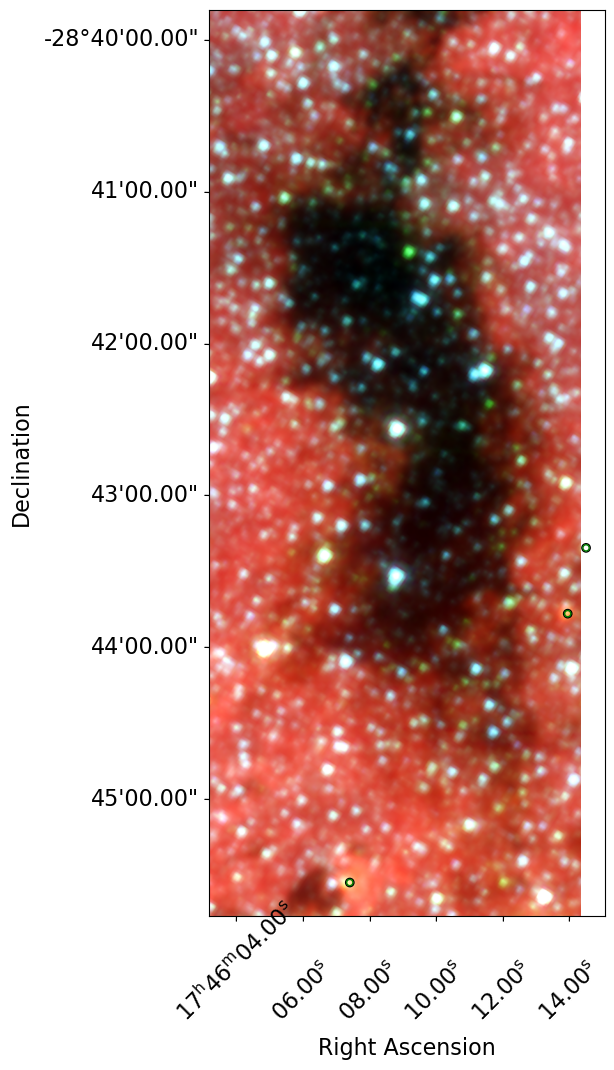

In [218]:
# This image shows only H-alpha stars
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickSpitzer_RGB_I421.png')
img_spitzer = np.array(PIL.Image.open(f'{basepath}/images/BrickSpitzer_RGB_I421.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_spitzer = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

img_spitzer = img_spitzer.swapaxes(0,1)
wwi_spitzer = wwi_spitzer.sub([2,1])

fig = pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_spitzer)
ax.imshow(img_spitzer)
axlims = ax.axis()

xx,yy = wwi_spitzer.world_to_pixel(an2011crds[wwi_spitzer.footprint_contains(an2011crds)])
ax.scatter(
    xx,yy,
    #spitzer_crds.ra[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #spitzer_crds.dec[spitzer['_4.5mag'] - spitzer['_8.0mag'] < 0],
    #transform=ax.get_transform('fk5'),
    marker='o', edgecolors='black', facecolors='none',
    #markeredgewidth=0.5,
    # for non-x facecolors='none'
    #edgecolors=(0.3, 0.5, 0.8), a 
);
ax.scatter(
    xx,yy,
    s=20,
    marker='o', edgecolors='g', facecolors='none',
);
#ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))
ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')

ra = lon = ax.coords['ra']
dec = lat = ax.coords['dec']
lon.set_major_formatter('hh:mm:ss.ss')
lat.set_major_formatter('dd:mm:ss.ss')
lon.set_ticks(spacing=30. * u.arcsec)
lon.set_ticklabel(rotation=45, pad=60)
#lat.set_ticks(spacing=30. * u.arcsec, color='blue')



#ax.axis(axlims)

dec.set_ticks_position('l')
dec.set_ticklabel_position('l')
dec.set_axislabel_position('l')
ra.set_ticks_position('b')
ra.set_ticklabel_position('b')
ra.set_axislabel_position('b')
#fig.savefig(f"{basepath}/images/BlueStarsWithSpitzerMatches_on_RGB.png", bbox_inches='tight')